# Lab 3: Ensemble Approaches

In this notebook, we are going to be focusing on the Ensemble methods. As you learned in the class, decision trees can be used to predict and classify data features. To improve on the simple decision tree, we can use ensemble methods such as Bagging and Random Forest. In an Ensemble approach, the algorithm acts as a group of experts analysing your data and the results is the aggregation of those individual analyses. 

A quick refresher on Bagging
- Grow multiple decisions of random subsets of the data
- All features are considered at every split in the decision tree
- The result is the average prediction of all trees

A quick refresher on the Random Forest theory:
- Random Forest is based on Decision Trees -> many trees = a forest!
- Grows multiple trees on random subsets of the parent dataset
- **At every split, a new random subset of features is chosen**
- This leads to "decorrelated" trees which leads to a large increase in performance!


## **If you haven't already, please run through Notebook 1 & 2!**  You need the final ouput df_module_2_w_outliers.csv.

As a reminder, we had 3 raw data files (loans_full, loans_detail, and loans_partner_details). In Notebook 1 module_1_exploratory_analysis_with_solutions, we merged these data files and created new variables to form the data frame "df_module_1", we exported it as df_module_1.csv. Then in module 2, we engineered several features and removed outliers and exported this to df_module_2_w_outliers.csv. We will use this dataframe now. 


First step is to import the libraries we want to use. Notice there is a new one below - sklearn.ensemble.

Sklearn is a suite of libraries that contain a range of machine learning tools. Today we are taking the RandomForestRegressor from the sklearn ensemble library. For more information on sklearn, check out their [diagram](http://scikit-learn.org/stable/tutorial/machine_learning_map/) for when and where to use difference machine learning methods.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from ggplot import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
import re
plt.style.use('ggplot')
%matplotlib inline

# the command below means that the output of multiple commands in a cell will be output at once.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# the command below tells jupyter to display up to 80 columns, this keeps everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)


To get more information about a new modules you have imported, run the cell below. A window containing a description of the module will appear! This provides details on the module parameters and attributes and links for further references. Try it out!

In [2]:
RandomForestRegressor?

You can also visit their page on [RandomForestReggresors](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), or visit their helpful [User Guide](http://scikit-learn.org/stable/modules/ensemble.html#forest) for Ensemble Approaches.

Next we import the entire dataset and the kiva data dictionary

In [3]:
# Read in data
data_path = '~/intro_course_data_science_for_good/data/'
df = pd.read_csv(data_path+'df_module_2_w_outliers.csv', low_memory=False)

FileNotFoundError: File b'C:\\Users\\PC/intro_course_data_science_for_good/data/df_module_2_w_outliers.csv' does not exist

## What questions should we ask?
To begin with we need to think about what question are we trying to answer with our Random Forest algorithms. 

In this notebook we will focus predominantly on the Regressor module so that we can compare our results to the previous class. **Therefore, we will be looking at how we can predict the loan amount using RandomForestRegressor.**

However, Random Forest can also be used to classify data, for example some interesting classification questions we could investigate are:
- Can we classify which loans expired and which one got funded?
- Is a loan posted by a male or female?

Feel free to investigate these on your own time! Here is a very simple example of how the RandomForestClassifier works: https://bicorner.com/2015/10/26/random-forest-using-ipython/

Let's start with **loan amount** and see if we can predict how much is requested to be funed using the RandomForestRegressor! 

## Creating Explanatory Features of Interest
For the sake of comparison we will use similar features as in the previous class where we used linear regression to predict the loan amount. 

We will also create a few more features that we think may be useful in the random forest.

The first new feature we create is 'video'. This indicates whether the loan has a video associated with it or not and has a boolean (True or False) data type

In [38]:
df['video'] = np.where(pd.isnull(df['video.id']) ==False, True, False)

At present, our columns for gender has two values, either female or male. To use these features in the RandomForest Algorithm we need a feature with either a boolean or numeric datatype. Therefore, we create a new feature which = 1 if they are male and = 0 if they are female.

In [39]:
df['male'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)

The following features that we create are: time for the loan to be funded, time for the loan to be dispersed and convert the posted date to a purely numeric column as we will want it in this format later on

In [40]:
## Time to fund is the funded date minus the posted date
df['time_to_fund'] =pd.to_datetime(df['funded_datetime']) - pd.to_datetime(df['posted_datetime'])
df['days_to_fund'] = df.time_to_fund.dt.days

## Time to dispursement is the Disbursed date minus the Posted Date
df['time_to_dispersal'] =pd.to_datetime(df['dispursal_datetime']) - pd.to_datetime(df['posted_datetime'])
df['days_to_dispersal'] = df.time_to_dispersal.dt.days

# Convert string into numeric for posted_date
df["posted_date_unix"] = pd.to_datetime(df['posted_date']).apply(lambda x: time.mktime(x.timetuple()) if not pd.isnull(x) else 0)

There are some erroneous values in the days_to_fund feature which must the results of an incorrect posted or funded date. Therefore lets remove the data point where days_to_fund are negative. Luckily this only corresponds to 25 records. 

In [103]:
# There are some erroneous values in the days_to_fund features so lets remove 
df['days_to_fund'].max()
df['days_to_fund'].min()
df[df['days_to_fund'] < 0]['days_to_fund'].value_counts()
df = df[df['days_to_fund']>=0]
#check that has worked
df['days_to_fund'].min()

62.0

0.0

Series([], Name: days_to_fund, dtype: int64)

0.0

The following features we are going to create are a bit more involved. We want to look aggregate loan statistics per month. The code below calculates the following for each month in the Kiva dataset: number of loans posted, number of loans expired, mean loan amount, and mean loan amount for expired loans. 

In [110]:
# number of loans posted in a given month
num_posted = pd.DataFrame(df.groupby(['posted_month', 'posted_year']).count()['activity'])
num_posted.columns = ['num_posted']
# number of loans expired in a given month
num_expired = pd.DataFrame(df[df['status']=='expired'].groupby(['posted_month', 'posted_year']).count()['activity'])
num_expired.columns = ['num_expired']
# mean loan in a given month
mean_loan = pd.DataFrame(df.groupby(['posted_month', 'posted_year']).mean()['loan_amount'])
mean_loan.columns = ['mean_loan']
# mean loan of expired loans in that month
mean_expired_loan = pd.DataFrame(df[df['status']=='expired'].groupby(['posted_month', 'posted_year']).mean()['loan_amount'])
mean_expired_loan.columns = ['mean_expired_loan']
# Adding these to the dataframe
df = df.merge(num_posted, left_on=['posted_month', 'posted_year'], right_index=True, how='outer')
df = df.merge(num_expired, left_on=['posted_month', 'posted_year'], right_index=True, how='outer')
df = df.merge(mean_loan, left_on=['posted_month', 'posted_year'], right_index=True, how='outer')
df = df.merge(mean_expired_loan, left_on=['posted_month', 'posted_year'], right_index=True, how='outer')


In [112]:
mean_loan.sort_index(level = ['posted_year','posted_month'],inplace=True)
mean_loan

,,mean_loan
posted_month,posted_year,
4,2006,225.000000
5,2006,340.789474
6,2006,332.031250
7,2006,374.193548
8,2006,310.227273
9,2006,435.714286
10,2006,330.555556
11,2006,701.181102
12,2006,615.373563


Lets plot a line graph of the mean loan over time. There are some interesting results here. We can see that the mean loan changes a lot over time.

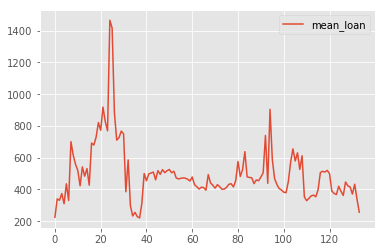

In [106]:
plt.plot(mean_loan['mean_loan'].values, label='mean_loan')
plt.legend()
plt.show()

Out of interest, we are also going to pick out some other features from the description. We chose some random and common words to see if they have any affect. 

In [113]:
# Some additional text features from the use description
df['motor'] = df['use'].apply(lambda x: 1 if type(x)==str and 'motor' in x.lower() else 0)
df['more'] = df['use'].apply(lambda x: 1 if type(x)==str and 'more' in x.lower() else 0)
df['solar'] = df['use'].apply(lambda x: 1 if type(x)==str and 'to purchase a solar light ' in x.lower() else 0)


Lastly, we look at the number of tags that the loan has associated with it. 

In [114]:
df['num_tags'] = df['tags'].apply(lambda x: x.count(','))

## Features to include in the analysis

Let's now list the features that we want to use in the random forest algorithm.
Sklearn's RandomForestRegressor can only handle boolean or numeric variables, so we will need to one-hot encode
some of the string variables further on. 

One of the advantages of the RandomForest algorithms is that we can pass through a whole range of features, regardless of whether we believe there is a linear relationship between the target (loan amount) and the feature and then find out which features have the highest influence. Remember from the course notes, the RandomForest Algorithms are based on the concept of decision trees where the set of all possible values are split into non-overlapping groups. 

This can be really powerful tool as it requires less initial investigation and analysis than a regression analysis.

The code below reduces the dataframe to the feature columns we want to include, creates a copy of this df which is the **training array**, pulls out the feature that we are trying to predict and stores this as a separate **training results** array.

In [115]:
# list of features that we think may be interested to include
cols = df[['loan_amount', 'num_tags','days_to_fund','days_to_expire','posted_date_unix','borrower_count','posted_month','activity', 'location.town', 'partner_id', 'sector', 'tags', 'male', 'widowed', 'kids', 'video', 'num_posted', 'motor', 'more', 'solar','partner_loans_posted','partner_delinquency_rate','age_int']]
# create a copy of the dataframe
rf_trainArr = cols.copy()
rf_trainArr = rf_trainArr.dropna()
# create a training array = all the features but not the target and a training test array = the results of the target variable for the training array
rf_trainRes = rf_trainArr['loan_amount']
rf_trainArr = rf_trainArr.drop('loan_amount', axis=1)


One of the features here is tags which includes a range of different tags. Although we created fields for some of this tags in module 2 (eco-friendly, animal and technology'), we going to expand this further in this module. It's is also a good opportunity to introduce you to some additional methods to engineer features.

In [116]:
rf_trainArr['tags'].value_counts()

[]                                                                                                                                                                                                                    17299
[{'name': 'user_favorite'}]                                                                                                                                                                                            1129
[{'name': '#Woman Owned Biz'}, {'name': '#Parent'}]                                                                                                                                                                    1045
[{'name': '#Woman Owned Biz'}, {'name': '#Parent'}, {'name': '#Repeat Borrower'}]                                                                                                                                       668
[{'name': '#Parent'}]                                                                                                   

Lets create some boolean variables for tags that we think may be interesting and seperate them out into individual features

In [117]:
tag_vals = ["#Woman Owned Biz", "#Parent", "user_favorite", "#Repeat Borrower", "#Schooling", "volunteer_pick", "#Vegan", "volunteer_like","#Animals", "#Eco-friendly", "#Technology"]
for tag in tag_vals:
    if tag not in rf_trainArr.columns:
        rf_trainArr['tag_'+str(tag)] = rf_trainArr['tags'].apply(lambda x: 1 if tag in x else 0)


In [118]:
rf_trainArr = rf_trainArr.drop(['tags'], axis=1)

In addition, there are some features which have a large range of possible responses. Instead of using each possible response as a features, we will just take the top 10. So example, lets look at the top activities:

In [119]:
rf_trainArr['activity'].value_counts().index[0:10]

Index(['Farming', 'Dairy', 'Agriculture', 'Fruits & Vegetables', 'Retail',
       'General Store', 'Clothing Sales', 'Poultry', 'Cereals', 'Tailoring'],
      dtype='object')

The following code takes the top ten occurences for activity, partner_id, location.town and sector and creates a features for each one

In [120]:
cols_to_separate = ['activity','partner_id','location.town','sector']
for col in cols_to_separate:
    # Find the top ten responses
    col_vals = rf_trainArr[col].value_counts().index[:10]
    for col_val in col_vals:
        # for each response, create a new feature column and assign binary responses: 1 for yes and 0 for no
        if col_val not in rf_trainArr.columns:
            rf_trainArr[col+'_'+str(col_val)] = rf_trainArr[col].apply(lambda x: 1 if x == col_val else 0)
    rf_trainArr = rf_trainArr.drop(col, axis=1)


Lets check our list of features again to make sure the code above worked correctly

In [121]:
rf_trainArr.columns

Index(['num_tags', 'days_to_fund', 'days_to_expire', 'posted_date_unix',
       'borrower_count', 'posted_month', 'male', 'widowed', 'kids', 'video',
       'num_posted', 'motor', 'more', 'solar', 'partner_loans_posted',
       'partner_delinquency_rate', 'age_int', 'tag_#Woman Owned Biz',
       'tag_#Parent', 'tag_user_favorite', 'tag_#Repeat Borrower',
       'tag_#Schooling', 'tag_volunteer_pick', 'tag_#Vegan',
       'tag_volunteer_like', 'tag_#Animals', 'tag_#Eco-friendly',
       'tag_#Technology', 'activity_Farming', 'activity_Dairy',
       'activity_Agriculture', 'activity_Fruits & Vegetables',
       'activity_Retail', 'activity_General Store', 'activity_Clothing Sales',
       'activity_Poultry', 'activity_Cereals', 'activity_Tailoring',
       'partner_id_133.0', 'partner_id_138.0', 'partner_id_164.0',
       'partner_id_156.0', 'partner_id_202.0', 'partner_id_388.0',
       'partner_id_203.0', 'partner_id_386.0', 'partner_id_277.0',
       'partner_id_324.0', 'location.to

## Training the algorithm
The next stage is training and testing the algorithm! To do this we need to create two subsets of data, one which we will train the algorithm on and the other we can test it on. To do this we will use the sklearn model selection function train_test_split. If you look back to the top of this page, we imported this function at the beginning of the notebook.

The names used below (X_train, X_test, y_train, y_test) are the conventions for training and testing data so best to try and train yourselves to use them.

In [122]:
X_train, X_test, y_train, y_test = train_test_split(rf_trainArr, rf_trainRes, test_size=0.2, random_state=42)

### Decision Tree
Before we get into some of the more sophisticated models, let's first try an individual Decision Tree and see how it performs.  After training the model, we will be able to assess it's performance by using sklearns useful method .score, which calculates the r2 value for the data provided.  We will first print out the r2 score for the training data, and then will print out the r2 score for the test data.

In [123]:
from sklearn.tree import DecisionTreeRegressor
decision_regressor = DecisionTreeRegressor(random_state=0)
decision_regressor.fit(X_train, y_train)
print("Train score: " + str(decision_regressor.score(X_train, y_train)))
print("Test score: " + str(decision_regressor.score(X_test, y_test)))

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

Train score: 0.999898489631
Test score: 0.540672890319


The R^2 number above are pretty telling but it is always nice to visualise how these look in a scattor plot. This also gives a visualisation of how to predicted values vary from the true values. 

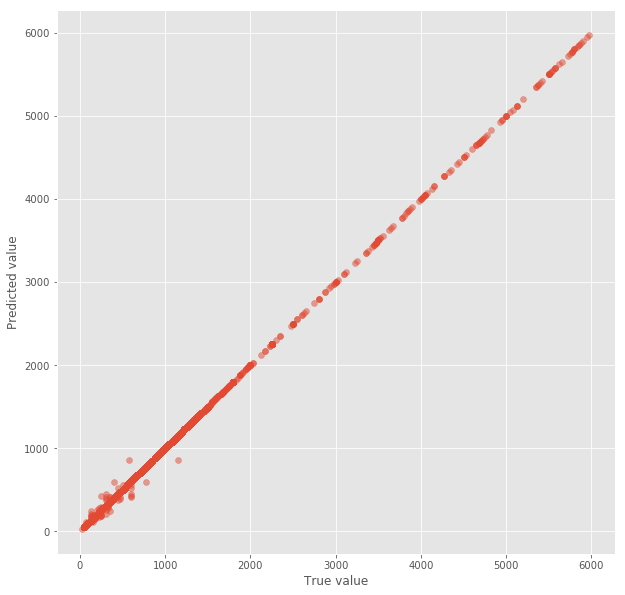

In [124]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
y_predicted_train_DT = decision_regressor.predict(X_train)
fig = plt.figure(figsize=(10, 10))
plt.scatter(y_train, y_predicted_train_DT, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

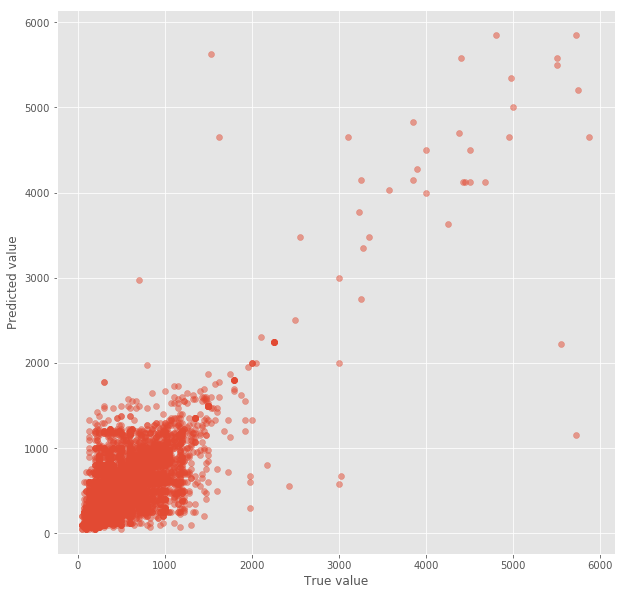

In [125]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
y_predicted_test_DT = decision_regressor.predict(X_test)
fig = plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_predicted_test_DT, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

## Bagging
The decison tree regressor is near perfect on the training data; however, much worse on the test data.  This is largely due to an individual Trees likelihood of overfitting to the data. Remember overfitting can occur when the tree goes to deep, the minimum leaf sample if too small or the maximum number number of terminal nodes is too high. These are all hyperparameteres and often it is very time consuming and difficult to decide the optimal hyperparameters. 

Another approach to overcome this is to build a collection of trees with sklearn's BaggingRegressor.  A bagging regressor builds some specified number of trees and trains each tree with a random subset of the data and then averages the forecast of each individual tree. 

This is an **Ensemble approach**

In [126]:
from sklearn.ensemble import BaggingRegressor
bagging_regressor = BaggingRegressor(oob_score=True)
bagging_regressor.fit(X_train, y_train)
print("Train score: " + str(bagging_regressor.score(X_train, y_train)))
print("Test score: " + str(bagging_regressor.score(X_test, y_test)))

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:986: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
         verbose=0, warm_start=False)

Train score: 0.952619775921
Test score: 0.715887691429


Due to the fact that we only consider a random subset of the data for each tree, we can also measure error using the out-of-bag score.  The out-of-bag score calculates the error for each observation that was not used while training an individual tree (Remember ~2/3 of data are used to train a given tree).

In [127]:
bagging_regressor.oob_score_

0.65593393005446221

The results above show that the train score has reduced but the test score has increased. This is a good sign as it means that the algorithm is overfitting less and therefore improving its ability to predict unseen loan amounts. 

When comparing the different regression models, we will be looking at three main outputs:
- Train score = R^2 between the predicted and true values for the training dataset
- Test score = R^2 between the predicted and true values for the test dataset
- Oob_score = the error rate of predicted values for data not used whilst training an individual tree

Therefore, we are defining a function below that prints out these score's us

In [128]:
# Since we will evaluate a few models, let's define a function that prints out the scores we care about
def print_scores(regressor, X_train, y_train, X_test, y_test, oob_score=True):
    print("Train score: " + str(regressor.score(X_train, y_train)))
    print("Test score: " + str(regressor.score(X_test, y_test)))
    print("OOB score: " + str(regressor.oob_score_))

In [129]:
print_scores(bagging_regressor, X_train, y_train, X_test, y_test, oob_score=True)

Train score: 0.952619775921
Test score: 0.715887691429
OOB score: 0.655933930054


### Changing some model parameters

The default number of trees used in the bagging regressor is 10. This means that the algorithms splits the dataset into 10 different tress, trains each one individually, predicts the result from each one individually and then averages the result. 

Let's see how performance changes when we increase the number of trees from 10 to 100.

In [130]:
bagging_regressor = BaggingRegressor(n_estimators=100, oob_score=True)
bagging_regressor.fit(X_train, y_train)
print_scores(bagging_regressor, X_train, y_train, X_test, y_test, oob_score=True)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
         verbose=0, warm_start=False)

Train score: 0.96483348418
Test score: 0.733066751608
OOB score: 0.746781649337


Here we see an improvement in all score and in particular the oob_score. This is telling us that splitting the dataset into more tree leads to a more accurate average predicton.

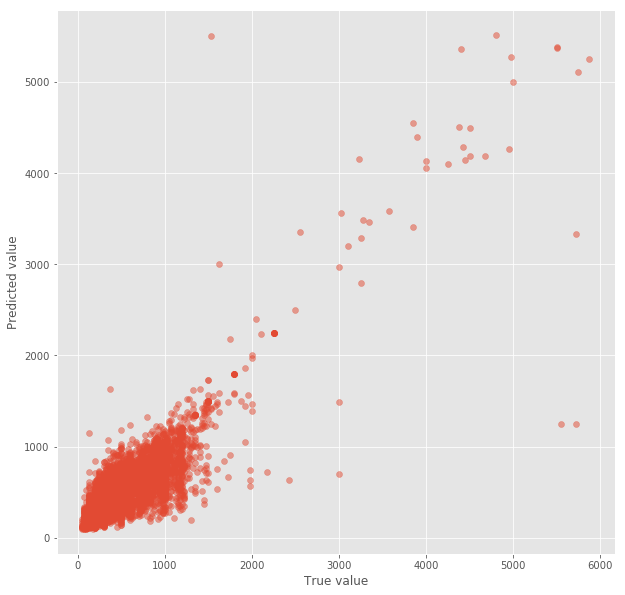

In [131]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
y_predicted_test_BR = bagging_regressor.predict(X_test)
fig = plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_predicted_test_BR, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

## Random Forest
We still observe a large discrepancy between the training data and the test data.  This is largely because the decision trees are largely correlated.  To de-correlate the trees, we can use a Random Forest Regressor, which only considers a random subsample of the features at each split.

Recall that the difference between the Bagging Regressor and the RandomForest is that in the RandomForest, at each split, a random subset of features is considered. The reducing the chance of correlation between the different trees. 

In [132]:
rf_regressor = RandomForestRegressor(n_estimators=100, oob_score=True)
rf_regressor.fit(X_train,y_train)
print_scores(rf_regressor, X_train, y_train, X_test, y_test, oob_score=True)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

Train score: 0.964764346854
Test score: 0.734480250382
OOB score: 0.74652345678


WOW! that was unexpected - there is very little change between the bagging regressor and the random forest algorithm. This indicates that the features we are using are already highly uncorrelated.

42876.971561454091

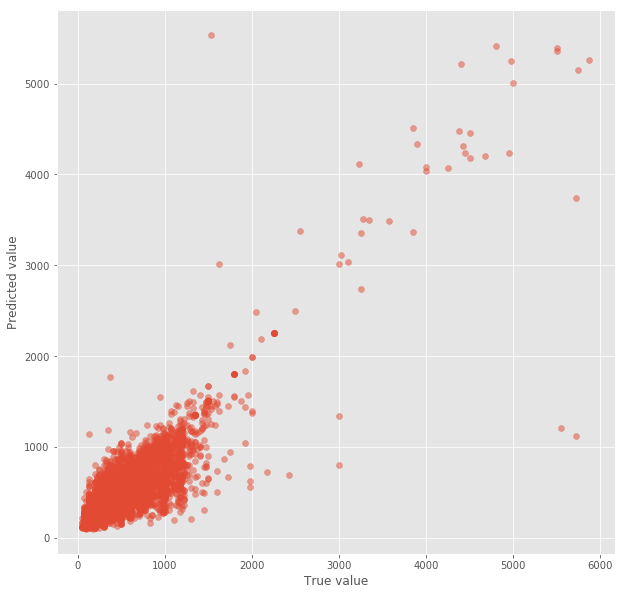

In [133]:
y_predicted_test = rf_regressor.predict(X_test)
mean_squared_error(y_test, y_predicted_test)

fig = plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_predicted_test, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

Now, let's try to figure out which features are driving our model's predictions.  Although we do not have the coefficients provided by a linear regression, we can analyze what percentage of the overall variance was explained by a given feature.

In [134]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]

print('Feature Ranking:')
for f in range(len(importances)):
    print("%d. feature %s (%f)" % (f + 1, rf_trainArr.columns[indices[f]], importances[indices[f]]))

Feature Ranking:
1. feature borrower_count (0.294531)
2. feature posted_date_unix (0.285808)
3. feature days_to_fund (0.102509)
4. feature partner_loans_posted (0.069172)
5. feature age_int (0.038622)
6. feature partner_delinquency_rate (0.025120)
7. feature num_posted (0.015820)
8. feature location.town_Kisii (0.014947)
9. feature posted_month (0.014513)
10. feature num_tags (0.012483)
11. feature partner_id_156.0 (0.005769)
12. feature male (0.005638)
13. feature tag_user_favorite (0.005374)
14. feature tag_#Repeat Borrower (0.005108)
15. feature more (0.005060)
16. feature sector_Health (0.005015)
17. feature sector_Education (0.004548)
18. feature days_to_expire (0.004247)
19. feature location.town_Kitale (0.004207)
20. feature sector_Agriculture (0.004119)
21. feature kids (0.003892)
22. feature activity_Farming (0.003590)
23. feature partner_id_202.0 (0.003435)
24. feature tag_#Woman Owned Biz (0.003008)
25. feature partner_id_164.0 (0.002905)
26. feature sector_Retail (0.002890)

Lets visualise the impact of some of the top features:

The borrower count is an intuitive features, the more people on the loan, the greater the loan will be. Lets look at this relationship again:

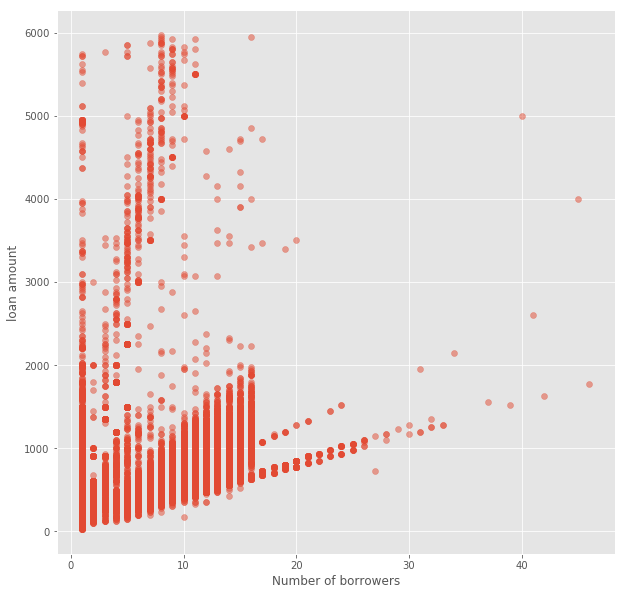

In [135]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(df['borrower_count'], df['loan_amount'], alpha=0.5)
plt.xlabel('Number of borrowers')
plt.ylabel('loan amount')
plt.show()

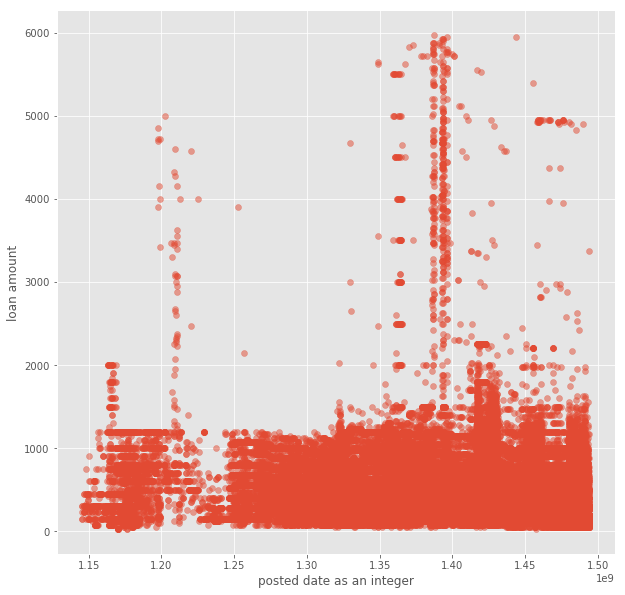

In [136]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(df['posted_date_unix'], df['loan_amount'], alpha=0.5)
plt.xlabel('posted date as an integer')
plt.ylabel('loan amount')
plt.show()

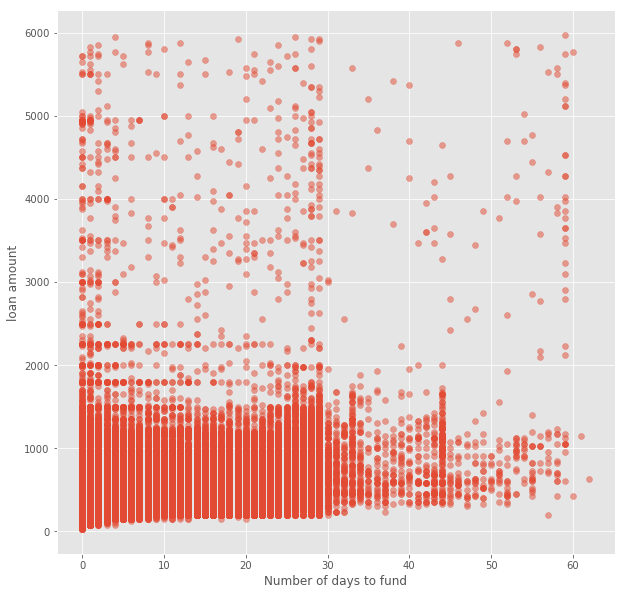

In [137]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(df['days_to_fund'], df['loan_amount'], alpha=0.5)
plt.xlabel('Number of days to fund')
plt.ylabel('loan amount')
plt.show()

There is not a very clear relationship between a single feature and the loan_amount which goes to show that the combination of features is required to achieve a good prediction.

Let's try taking the top 20 features and observe it's impact on performance

In [138]:
relevant_cols = [rf_trainArr.columns[indices[f]] for f in range(20)]
X_train2, X_test2 = X_train[relevant_cols], X_test[relevant_cols]

In [139]:
rf2 = RandomForestRegressor(n_estimators=100, oob_score=True)
rf2.fit(X_train2,y_train)
print_scores(rf2, X_train2, y_train, X_test2, y_test, oob_score=True)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

Train score: 0.96354260079
Test score: 0.724807332096
OOB score: 0.739316859868


The scores haven't changed significantly which means that we can continue just using the top 20 features. This means the algorithms must faster and gives us a clearer idea of which features affect the loan amount

Before we move onto homework, remember to output your final dataframe so you don't have to rerun it.

In [ ]:
df.to_csv(data_path+'df_module_3.csv')

## Homework

Repeat the BaggingRegressor and the RandomForestRegressor method with a new target feature: days_to_fund. Determine the monst important features and discuss which features are intuitive or a surprise and why. 


In [147]:
# adding the loan_amount feature back into the rf_trainArr dataset
rf_trainArr['loan_amount'] = rf_trainRes
# The new target feature result is the days_to_fund so pull that out and drop it from the training array
rf_trainRes = rf_trainArr['days_to_fund']
rf_trainArr = rf_trainArr.drop('days_to_fund', axis=1)

In [ ]:
# Create X_train, y_train, X_test and y_test where the y value is the days_to_fund feature. 
# Try using test_train_split function imported from sklearn

In [ ]:
# Use the BaggingRegressor method to predict the days_to_fund

In [ ]:
# Use the RandomForest Regressor method to predict the days_to_fund

In [ ]:
# Find the most important features

## Advanced Homework (optional)

The sklearn RandomForest library also has a classifier method, which rather than predicting a continuous numerical value such as loan amount or days to fund, it attempted to classify data on existing labels, eg: male or female. 

We imported this method at the beginning and you can read more about it here using the following cell or by going the sklearn [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) webpage.

In [148]:
RandomForestClassifier?

Using this module and the original feature gender, see how well we can classify loans by the gender. The procedure for training and testing data is practically the same as the RandomForestRegressor and the score is the mean accuracy of the predictions rather than the R^2 of the regression. 

## Advanced Material: Optimising the algorithm

Up to this point, we have been largely been using the default values for all of the hyper-parameters.  To increase perfromance we should try adjusting these parameters.  Sklearn's GridSearchCV uses cross-validation to assess the performance of each possible permutation of the hyper-parameters that you specify.

In [140]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [100, 300, 500],
             'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [None, 5, 10]
             }
gridrf = RandomForestRegressor()
grid_rf = GridSearchCV(gridrf, parameters)

In [141]:
grid_rf.fit(X_train2, y_train)

KeyboardInterrupt: 

To find out which set of parameters performed best, we can use the .best\_pramas\_ method

In [ ]:
grid_rf.best_params_

Next, let's check out the variation in performance.

In [ ]:
means = grid_rf.cv_results_['mean_test_score']
stds = grid_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))